## Packages and Imports
In this tutorial, you will learn how to quantify model uncertainty using enemble, Monte Carlo dropout, and evidential deep learing techniques. To start with this notebook, you need to install three packages: 
- MONAI: A framework for deep learning in medical image analysis.
- timm: A rich collection of many deep learning models pretrained on natural images.
- Net:Cal: A package for model output calibration.

In [1]:
from glob import glob
import random
import os
import copy
from tqdm import tqdm
import monai as mn
import numpy as np
import torch
import timm
import math

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.calibration import calibration_curve

c:\Users\ammar\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preperation
For this notebook we will use a dataset from [Kermany et. al.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810) that has a set of more than 5,000 pediatric chest radiographs, with and without pneumonia. We use MONAI for dataset preperation, as it has several medical image-specific augmentations and enables using them with a very simple interface. 

We create out datasets and dataloaders one here and use it in all of the upcomming experiments. In brief the following cell takes care of the following:

1. Gets the list of files in the train, validation, and test folders of the dataset.
2. Creates a dictionary of these file paths with their corresponding label (normal or pneumonia) to leverage MONAI's dictionary based augmentation pipeline.
3. Defines training and validation transforms.
4. Created datasets and dataloaders for each of the three sets.

In [4]:
# Global Variables
DATA_DIR = 'data'
MONAI_CACHE_DIR = 'data/cache_UQ'
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 3
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
MODEL_ARCHITECTURE = "convnext_small"

# 1. Gets the list of files in the train, validation, and test folders of the dataset.
train_files = glob(f"{DATA_DIR}/train/*/*.jpeg")
val_files = glob(f"{DATA_DIR}/val/*/*.jpeg")
test_files = glob(f"{DATA_DIR}/test/*/*.jpeg")

# 2. Creates a dictionary of image paths and labels.
def get_data_dict(files:list)-> dict:
    """creates a dictionary of image paths and labels

    Args:
        files (list): list of image paths

    Returns:
        dict: dictionary of image paths and labels
    """
    final_dict = []
    for file in files:
        label = file.split("/")[-2]
        if label == "NORMAL":
            label = 0
        else:
            label = 1
        final_dict.append({"img": file, "label": label})

    return final_dict

train_data = get_data_dict(train_files)
val_data = get_data_dict(val_files)
test_data = get_data_dict(test_files)

# 3. Defines training and validation transforms.
train_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=["img"]),
    mn.transforms.EnsureChannelFirstD(keys=["img"]),
    mn.transforms.LambdaD(keys=["img"], func=lambda x: x[0:1, :,:]),
    mn.transforms.ScaleIntensityd(keys=["img"],minv=0.0, maxv=1.0,),
    mn.transforms.ResizeD(keys=["img"], spatial_size=IMG_SIZE, size_mode="longest"),
    mn.transforms.SpatialPadD(keys=["img"], spatial_size=IMG_SIZE, method="symmetric"),
    mn.transforms.RandAffineD(keys='img', rotate_range=0.25, translate_range=int(IMG_SIZE * 0.05), scale_range=0.1, mode="bilinear", padding_mode="zeros", prob=0.8),
    mn.transforms.RandFlipD(keys='img', spatial_axis=1, prob=0.5),
    mn.transforms.RandGaussianNoiseD(keys='img', mean=0.5, std=0.2, prob=0.5),
    mn.transforms.ToTensorD(keys=["img"]),
    mn.transforms.ToTensorD(keys=["label"], dtype=torch.long),
    mn.transforms.SelectItemsD(keys=["img","label"]),
])

val_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=["img"]),
    mn.transforms.EnsureChannelFirstD(keys=["img"]),
    mn.transforms.LambdaD(keys=["img"], func=lambda x: x[0:1, :,:]),
    mn.transforms.ResizeD(keys=["img"], spatial_size=IMG_SIZE, size_mode="longest"),
    mn.transforms.SpatialPadD(keys=["img"], spatial_size=IMG_SIZE, method="symmetric"),
    mn.transforms.ToTensorD(keys=["img"]),
    mn.transforms.ToTensorD(keys=["label"], dtype=torch.long),
    mn.transforms.SelectItemsD(keys=["img","label"]),
])

# 4. Creates a dataset and a dataloader.
train_ds = mn.data.PersistentDataset(data=train_data, transform=train_transforms, cache_dir=MONAI_CACHE_DIR)
val_ds = mn.data.PersistentDataset(data=val_data, transform=val_transforms, cache_dir=MONAI_CACHE_DIR)
test_ds = mn.data.Dataset(data=test_data, transform=val_transforms)

def get_dataloaders(train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, batch_size=BATCH_SIZE):
    """Creates a dataloader for the train, validation, and test datasets.

    Args:
        train_ds (PersistentDataset, optional): Training dataset. Defaults to train_ds.
        val_ds (PersistentDataset, optional): Validation dataset. Defaults to val_ds.
        test_ds (Dataset, optional): Test dataset. Defaults to test_ds.
        batch_size (int, optional): Batch size. Defaults to BATCH_SIZE.

    Returns:
        DataLoader: Dataloader for the train dataset.
        DataLoader: Dataloader for the validation dataset.
        DataLoader: Dataloader for the test dataset.
    """
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, worker_init_fn=seed_worker)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2, worker_init_fn=seed_worker)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, drop_last=False, num_workers=2, worker_init_fn=seed_worker)
    return train_loader, val_loader, test_loader

## Model Training
In this tutorial we will be dealing with several models and need to have a robust pipeline for training our deep learning models. In order to facilitate this process, we will create a function that takes care of training our models given the architecture, training seed and loss function. First we have to have some helper functions that take care of seeding training parameters (including the augmentation pipeline), calculating area under receiver operating curve (ROC) and also training on a single batch:

In [ ]:
def seed_everything(seed: int = 42):
    """sets the seed for all libraries

    Args:
        seed (int, optional): seed value. Defaults to 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    mn.utils.misc.set_determinism(seed=seed)


class AUCMetric(object):
    """
    Computes the Area Under the Curve (AUC) for binary classification.
    """
    def __init__(self):
        self.y_preds = []
        self.y_trues = []

    def __call__(self, y_pred, y_true):
        self.y_preds.append(y_pred)
        self.y_trues.append(y_true)

    def reset(self):
        self.y_preds = []
        self.y_trues = []

    def compute(self):
        y_preds = torch.cat(self.y_preds, dim=0).cpu().numpy()[:, 1]
        y_trues = torch.cat(self.y_trues, dim=0).cpu().numpy()
        auc = roc_auc_score(y_trues, y_preds)
        return auc

def one_step(model, batch, loss_fn, optimizer, device: str = "cuda:0", training: bool = True):
    """trains the model for one step

    Args:
        model (torch.nn.Module): model
        batch (dict): batch of data
        loss_fn (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer
        training (bool, optional): whether the model is in training mode or not. Defaults to True.

    Returns:
        float: loss value
    """
    x = batch["img"].to(device)
    y = batch["label"].to(device)

    if training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(training):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        if training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return loss.item(), torch.softmax(y_pred, dim=-1)

Now we can write our generic training function: 

In [ ]:
def train_model(architecture, loss_fn, weight_filename: str = "best_model", num_classes: int = 2, training_seed: int = 42, epochs: int = 10, device: str = "cuda:0"):
    """trains the model

    Args:
        architecture (torch.nn.Module): model architecture
        train_dataloader (torch.utils.data.DataLoader): train dataloader
        val_dataloader (torch.utils.data.DataLoader): validation dataloader
        loss_fn (torch.nn.Module): loss function
        training_seed (int): seed value
        epochs (int, optional): number of epochs. Defaults to 10.
        device (str, optional): device to use. Defaults to "cuda:0".

    Returns:
        torch.nn.Module: best weights of the trained model
    """
    # some hyperparameters that you can use to tune your model
    lr = 1e-4
    weight_decay = 1e-5

    seed_everything(training_seed)
    
    model = timm.create_model(architecture, pretrained=False, in_chans=1, num_classes=num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_auc = 0
    best_model = None
    validation_auc = AUCMetric()

    train_dataloader, val_dataloader, _ = get_dataloaders()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)
        train_losses = []
        val_losses = []
        for batch in tqdm(train_dataloader, desc="training"):
            train_loss, _ = one_step(model, batch, loss_fn, optimizer, device=device, training=True)
            train_losses.append(train_loss)

        validation_auc.reset()
        for batch in tqdm(val_dataloader, desc="validating"):
            val_loss, y_pred = one_step(model, batch, loss_fn, optimizer, device=device, training=False)
            val_losses.append(val_loss)
            validation_auc(y_pred, batch["label"])
            
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_auc = validation_auc.compute()
        print(f"train loss: {train_loss:.4f}")
        print(f"val loss: {val_loss:.4f}")
        print(f"val auc: {val_auc:.4f}")
        if val_auc > best_auc:
            best_auc = val_auc
            best_model = copy.deepcopy(model)
            print("saving best model")
            torch.save(best_model.state_dict(), f"{weight_filename}.pth")
        print("\n")

    return best_model

Let's train a simple model with `CrossEntropy` loss, which is the routine practice in many deep learning projects:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
best_model = train_model(
    architecture=MODEL_ARCHITECTURE,
    loss_fn=loss_fn,
    weight_filename="CE_seed_42",
    training_seed=42,
    num_classes=2,
    epochs=EPOCHS,
    device=DEVICE
)

Now let's checkout our model's calibration curve:

In [ ]:
def get_inference_results(weight_path, set_name='val'):
    model = timm.create_model(MODEL_ARCHITECTURE, pretrained=False, in_chans=1, num_classes=2).to(DEVICE)
    model.load_state_dict(torch.load(weight_path))
    model.eval()
    if set_name == 'val':
        _, dataloader, _ = get_dataloaders()
    elif set_name == 'test':
        _, _, dataloader = get_dataloaders()
    else:
        raise ValueError('set_name must be val or test')
    y_preds = []
    y_true = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            x = batch["img"].to(DEVICE)
            y = batch["label"].to(DEVICE)
            y_pred = model(x)
            y_preds.extend(torch.softmax(y_pred, dim=-1).cpu().numpy())
            y_true.extend(y.cpu().numpy())

    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    return np.array(y_preds), np.array(y_true)

y_preds, y_true = get_inference_results("CE_seed_42.pth", set_name='test')

100%|██████████| 624/624 [00:48<00:00, 12.74it/s]


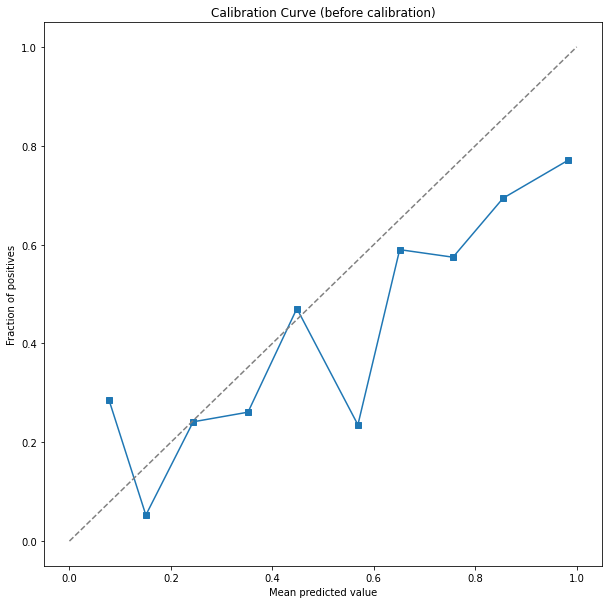

In [ ]:
def plot_calibration_curve(y_true, y_pred, n_bins=10, normalize=True, title="Calibration Curve", ax=None):
    """plots calibration curve

    Args:
        y_true (np.array): true labels
        y_pred (np.array): predicted labels
        n_bins (int, optional): number of bins. Defaults to 10.
        normalize (bool, optional): whether to normalize the data or not. Defaults to True.
        title (str, optional): title of the plot. Defaults to "Calibration Curve".
        ax (matplotlib.axes.Axes, optional): axes to plot on. Defaults to None.

    Returns:
        matplotlib.axes.Axes: axes
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=n_bins)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("Mean predicted value")
    ax.set_title(title)
    return ax

plot_calibration_curve(y_true, y_preds[:, 1], title="Calibration Curve (before calibration)");

After training our model, the next step toward having a more representative model is to calibrate our model's predictions. To do this, we use the `netcal` package:

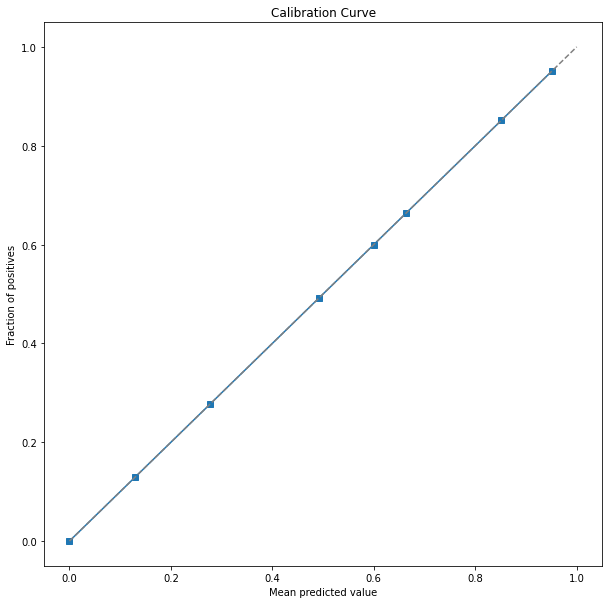

In [ ]:
from netcal.binning import IsotonicRegression

calibrator = IsotonicRegression()
calibrator.fit(y_preds, y_true)
y_preds_calibrated = calibrator.transform(y_preds)
plot_calibration_curve(y_true, y_preds_calibrated);

## UQ Techniques: Ensemble
To use this technique, we have to train our model with different initialization seeds. Then we can run a single image through all of those models and get a mean and standard deviation of their prediction. *The higher the standard deviation, the more uncertain the models are.*

In [ ]:
ensemble_models = [best_model]
training_seeds = [42, 43]
loss_fn = torch.nn.CrossEntropyLoss()
for seed in training_seeds[1:]: # we already trained the first model (seed=42)
    print("*" * 40)
    print(f"Training model with seed {seed}")
    print("*" * 40)
    ensemble_models.append(train_model(
        architecture=MODEL_ARCHITECTURE,
        loss_fn=loss_fn,
        weight_filename=f"seed_{seed}",
        training_seed=seed,
        num_classes=2,
        epochs=EPOCHS,
        device=DEVICE
    ))

Epoch 1/3
----------


validating: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


train loss: 0.5695
val loss: 0.8252
val auc: 0.9351
saving best model


Epoch 2/3
----------


validating: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]


train loss: 0.4704
val loss: 0.7985
val auc: 0.9319


Epoch 3/3
----------


validating: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


train loss: 0.4718
val loss: 1.0064
val auc: 0.9415
saving best model




In [ ]:
_, _, test_dataloader = get_dataloaders()
for i, item in enumerate(test_dataloader):
    if i >= 3 and i < (len(test_dataloader) - 3):
        continue # we only need a few samples

    img = item["img"].to(DEVICE)
    label = item["label"].to(DEVICE)
    y_preds = []
    for model in tqdm(ensemble_models):
        model.eval()
        with torch.no_grad():
            y_pred = model(img)
            y_preds.append(torch.softmax(y_pred, dim=-1).cpu().numpy()[:, 1].item())
    y_preds = np.array(y_preds)
    mean_pred = np.mean(y_preds)
    std_pred = np.std(y_preds)
    print(f"Predicted label: {mean_pred:.4f} (SD: {std_pred:.4f})")
    print(f"True label: {label.item()}")
    print()

100%|██████████| 2/2 [00:00<00:00, 27.45it/s]


Predicted label: 0.8833 (SD: 0.0449)
True label: 1



100%|██████████| 2/2 [00:00<00:00, 38.62it/s]


Predicted label: 0.9315 (SD: 0.0059)
True label: 1



100%|██████████| 2/2 [00:00<00:00, 22.78it/s]


Predicted label: 0.9285 (SD: 0.0067)
True label: 1



100%|██████████| 2/2 [00:00<00:00, 21.12it/s]


Predicted label: 0.6074 (SD: 0.0965)
True label: 0



100%|██████████| 2/2 [00:00<00:00, 37.33it/s]


Predicted label: 0.4223 (SD: 0.0654)
True label: 0



100%|██████████| 2/2 [00:00<00:00, 35.06it/s]


Predicted label: 0.9821 (SD: 0.0002)
True label: 0



## UQ Techniques: Monte Carlo Dropout

**What is dropout?**

A technique used during training in which we randomly set some of the neurons in a neural network to zero.
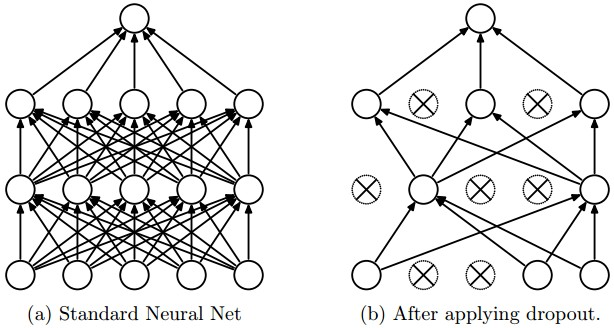

Image source: https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

**What's dropout function?**

This helps to prevent overfitting and improves the generalization of the model. 

**What is Monte Carlo dropout? How do we qunatify uncertainty with it?**

Training is finished and during inference we simply pass the same inputs (test set) through the trained model with different dropout masks applied at each pass. 
Each pass generates a different prediction for the input, which we can be treated as a sample from a probability distribution over the outputs.

We can then calculate various statistics on the set of predictions, such as the mean, variance, or percentiles. These statistics can be used to estimate the model's uncertainty and assess how confident we should be in its predictions.

*The higher the standard deviation, the more uncertain a model is.*

In [ ]:
model = best_model
model.eval()
number_of_iterations = 10 # number of iterations to run the dropout
# turn on dropout
for m in model.modules():
    if m.__class__.__name__.startswith("Dropout"):
        m.train()
        m.p = 0.1

_, _, test_dataloader = get_dataloaders()
for i, item in enumerate(test_dataloader):
    if i >= 3 and i < (len(test_dataloader) - 3):
        continue # we only need a few samples

    img = item["img"].to(DEVICE)
    label = item["label"].to(DEVICE)
    y_preds = []

    with torch.no_grad():
        for i in range(number_of_iterations):
            y_pred = model(img)
            y_preds.append(torch.softmax(y_pred, dim=-1).cpu().numpy()[:, 1].item())
    
    y_preds = np.array(y_preds)
    mean_pred = np.mean(y_preds)
    std_pred = np.std(y_preds)
    print(f"Predicted label: {mean_pred:.4f} (SD: {std_pred:.4f})")
    print(f"True label: {label.item()}")
    print()

Predicted label: 0.9282 (SD: 0.0000)
True label: 1

Predicted label: 0.9373 (SD: 0.0000)
True label: 1

Predicted label: 0.9352 (SD: 0.0000)
True label: 1

Predicted label: 0.7039 (SD: 0.0000)
True label: 0

Predicted label: 0.4877 (SD: 0.0000)
True label: 0

Predicted label: 0.9820 (SD: 0.0000)
True label: 0



## UQ Techniques: Evidential Deep Learning
As opposed to previouse methods evidential deep learning (EDL) is not a post-hoc (inference based) method. It requires training with specific loss functions. These specific loss functions (from now on we will refer to them as EDL losses) will assist the model in predicting a Dirichlet distribution for every input data point. In other words, the logits generated by our model will no longer be fed to a SoftMax layer, but will instead be slightly modified and interpreted as the alpha parameters of a Dirichlet distribution. The following cell demonstrates how this loss function is defined:


---
>
There are multiple ways to define the EDL loss function. For an extensive discussion of this topic, please refer to the [original paper](https://proceedings.neurips.cc/paper/2018/file/a981f2b708044d6fb4a71a1463242520-Paper.pdf).

---

#### Let's start with a question?

If the probability of a chest X-ray (CXR) showing pneumonia in a given population is 0.2, and the probability of a normal CXR is 0.8, what is the likelihood of randomly selecting ten CXRs and observing only three of them showing pneumonia? 

The probability of selecting 3 CXRs showing pneumonia out of 10 is 0.2013


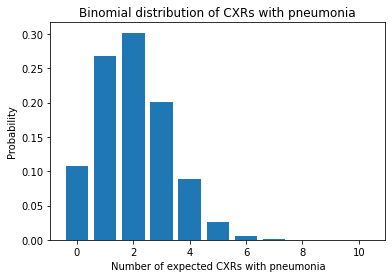

In [ ]:
# We will use bi(multi)nomial distribution to calculate the probabilities.
# Define variables
n = 10  # total number of CXRs
k = 3  # number of CXRs showing pneumonia
p_pneumonia = 0.2  # probability of CXR showing pneumonia
p_normal = 0.8  # probability of CXR being normal

# Calculate the probability
def calculate_probability (k,n = 10 , p_pneumonia = 0.2, p_normal = 0.8):
  prob = (math.comb(n, k) * pow(p_pneumonia, k) * pow(p_normal, n-k))
  return prob

# Print the result
print(f"The probability of selecting 3 CXRs showing pneumonia out of 10 is {calculate_probability(k=3):.4f}")
#Plot the distribiution
probabilities = []
for i in range(n+1):
  probability = calculate_probability(k= i)
  probabilities.append(probability)
plt.bar(range(n+1), probabilities);
plt.xlabel("Number of expected CXRs with pneumonia");
plt.ylabel("Probability");
plt.title("Binomial distribution of CXRs with pneumonia");

We solved the above problem with the assumption that the probabilities are known, but what if instead of knowing the exact probabilities, we want to first estimate the probabilities and then use those estimated probabilities to answer the above question? For instance, what is the likelihood of randomly selecting ten CXRs and observing only three of them showing pneumonia, if in a sample of 10 CXRs we find 2 CXRs with pneumonia and 8 normal CXRS.

Answer: Dirichlet distribustion is all you need!

### [Dirichlet distribustion](https://https://en.wikipedia.org/wiki/Dirichlet_distribution) (Distribiution of distribution!!):
(Dirichlet distribution is the multivariabel form of [Beta distribution](https://https://en.wikipedia.org/wiki/Beta_distribution) )
$$ f(\mathbf{x};\boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})}\prod_{i=1}^{r}x_i^{\alpha_i-1} $$

##### where:
$$ \alpha_i = e_i + 1 $$ (eᵢ is the logit of *i* th class)
$$ S = \sum\limits_{i=1}^K \alpha_i $$
K is the number of classes (in this example K=2).
##### Let's calculate the estimate of probabilities and uncertainty of the prediction:
\begin{align*}
u &= \frac{K}{S} &\qquad& \hat{p} = \frac{\alpha_k}{S}
\end{align*}
So all we need to claculate probabilities and uncertainty is evidence!

# How to train our DL model to learn to collect evidences?
We need a proper loss function!
\begin{equation}
\begin{aligned}
L_i(\Theta) &= Z(X) - \frac{1}{B(\alpha_i)}\sum_{j=1}^{K} y_{ij}\log(p_{ij}) + (\alpha_{ij} - 1)\log(p_{ij}) \
&= \sum_{j=1}^{K} y_{ij}\left(\psi(S_i)-\psi(\alpha_{ij})\right) + \log(B(\alpha_i)) - \log(Z(X)) \
&\quad - \sum_{j=1}^{K} \log(y_{ij}!) + (\alpha_{ij}-1)\log(p_{ij}) \
\end{aligned}
\end{equation}

# Is that enough? No 
\begin{equation}
L(\Theta) = \frac{1}{N}\sum_{i=1}^{N} L_i(\Theta) + \lambda_t \sum_{i=1}^{N} \mathrm{KL}\left[D\left(p_i | \tilde{\alpha_i}\right) | D\left(p_i | 1, \ldots, 1\right)\right]
\end{equation}
where:
\begin{equation}
\mathrm{KL}\left[D\left(p_i | \tilde{\alpha_i}\right) | D\left(p_i | 1\right)\right] = \log \frac{\Gamma\left(\sum_{k=1}^{K} \tilde{\alpha}{ik}\right)}{\Gamma(K)} + \sum{k=1}^{K} \left(\tilde{\alpha}{ik} - 1\right)\left(\psi(\tilde{\alpha}{ik}) - \psi\left(\sum_{j=1}^{K} \tilde{\alpha}_{ij}\right)\right)
\end{equation}
But don't worry about the math the following functions will take care all of these!

In [ ]:
class EDLLoss(torch.nn.Module):
    def __init__(self, annealing_step=0, num_classes=2):
        super().__init__()
        self.num_classes = num_classes
        self.annealing_step = annealing_step
    
    def _get_evidence(self, y):
        return torch.nn.functional.softplus(y)

    def _kl_divergence(self, alpha):
        device = alpha.device
        ones = torch.ones([1, self.num_classes], dtype=torch.float32, device=device)
        alpha_sum = torch.sum(alpha, dim=1, keepdim=True)
        first_term = (
            torch.lgamma(alpha_sum)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )
        second_term = (
            (alpha - ones)
            .mul(torch.digamma(alpha) - torch.digamma(alpha_sum))
            .sum(dim=1, keepdim=True)
        )
        kl = first_term + second_term
        return kl
    
    def _loglikelihood_loss(self, y, alpha):
        device = alpha.device
        y = y.to(device)
        alpha = alpha.to(device)
        alpha_sum = torch.sum(alpha, dim=1, keepdim=True)
        loglikelihood_err = torch.sum((y - (alpha / alpha_sum)) ** 2, dim=1, keepdim=True)
        loglikelihood_var = torch.sum(alpha * (alpha_sum - alpha) / (alpha_sum * alpha_sum * (alpha_sum + 1)), dim=1, keepdim=True)
        loglikelihood = loglikelihood_err + loglikelihood_var
        return loglikelihood

    def __call__(self, output, target, epoch_num=None):
        evidence = self._get_evidence(output)
        alpha = evidence + 1
        device = alpha.device
        if target.ndim == 1:
            y = torch.nn.functional.one_hot(target, num_classes=self.num_classes).float().to(device)
        else:
            y = target.to(device)
        alpha = alpha.to(device)
        loglikelihood = self._loglikelihood_loss(y, alpha)
        if self.annealing_step!= 0:
            assert epoch_num is not None, "epoch_num must be provided when using annealing"
            annealing_coef = torch.min(
                torch.tensor(1.0, dtype=torch.float32),
                torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32),
            )
        else:
            annealing_coef = 1.0
        kl_alpha = (alpha - 1) * (1 - y) + 1
        kl_div = annealing_coef * self._kl_divergence(kl_alpha)
        loss = (loglikelihood + kl_div).mean()
        return loss

# Dummy test
loss = EDLLoss()
trues = torch.randint(0, 2, (10,))
preds = torch.randn(10, 2)
print(trues.shape, preds.shape)
loss(preds, trues)

torch.Size([10]) torch.Size([10, 2])


tensor(0.8187)

Now let's retrain our model with the EDL loss function:

In [ ]:
loss_fn = EDLLoss()
edl_model = train_model(
    architecture=MODEL_ARCHITECTURE,
    loss_fn=loss_fn,
    weight_filename=f"edl_seed_42",
    training_seed=42,
    num_classes=2,
    epochs=3,
    device=DEVICE
)

Epoch 1/3
----------


validating: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


train loss: 0.5366
val loss: 0.5096
val auc: 0.9375
saving best model


Epoch 2/3
----------


validating: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


train loss: 0.4758
val loss: 0.5218
val auc: 0.9375


Epoch 3/3
----------


validating: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


train loss: 0.4683
val loss: 0.5155
val auc: 0.9688
saving best model




Finally, we can apply our model to a single image and perform a handful of calculations to obtain the calibrated probabilities and the prediction's uncertainty:

In [ ]:
def get_edl_probs(y_preds):
    if type(y_preds) != torch.Tensor:
        y_preds = torch.tensor(y_preds)
    evidence = torch.nn.functional.relu(y_preds)
    alpha = evidence + 1
    alpha_sum = torch.sum(alpha, dim=1, keepdim=True)
    probs = alpha / alpha_sum
    uncertainties = y_preds.shape[1] / alpha_sum
    return probs, uncertainties

In [ ]:
y_preds, y_true = get_inference_results("edl_seed_42.pth")
y_probs, uncertainties = get_edl_probs(y_preds)

for label, prob, uncertainty in zip(y_true, y_probs, uncertainties):
    # print(label, prob, uncertainty)
    print(f"Label: {label} | Prediction: {prob.argmax()} | Probablity: {prob.max().item():.3f} | Uncertainty: {uncertainty.item():.3f}")

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 1 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.667 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.666 | Uncertainty: 0.667
Label: 0 | Prediction: 0 | Probablity: 0.508 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.661 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.630 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.666 | Uncertainty: 0.667
Label: 0 | Prediction: 1 | Probablity: 0.648 | Uncertainty: 0.667
Label: 0 |

**Thank you for taking part in this tutorial!**